In [ ]:
import sys

sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os
import keras as keras

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer/"
    MODEL_DIR = "../models/model_8780384/"

else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"

CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)

data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], max_events=1_000_000, event_numbers="odd"
)
X,y = DataProcessor.get_data()
del DataProcessor

## Load Model and Setup Evaluator

In [10]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
    KerasFFRecoBase,
    ChiSquareAssigner,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
transformer = KerasFFRecoBase(data_config, use_nu_flows=True, name="Transformer")
MODEL_DIR = "../models/model_8780384/"
transformer.load_model(f"{MODEL_DIR}odd_model.keras")
chi_square_assigner = ChiSquareAssigner(data_config)

prediction_manager = Evaluation.PredictionManager(
    [ground_truth_assigner, transformer,chi_square_assigner], X, y
)

evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

Model loaded from ../models/model_8780384/odd_model.keras
Training history loaded from ../models/model_8780384/odd_model_history.npz


2026-01-28 15:53:19.117661: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2026-01-28 15:54:26.950415: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert



Computing binned accuracy quotients for truth_ttbar_mass...


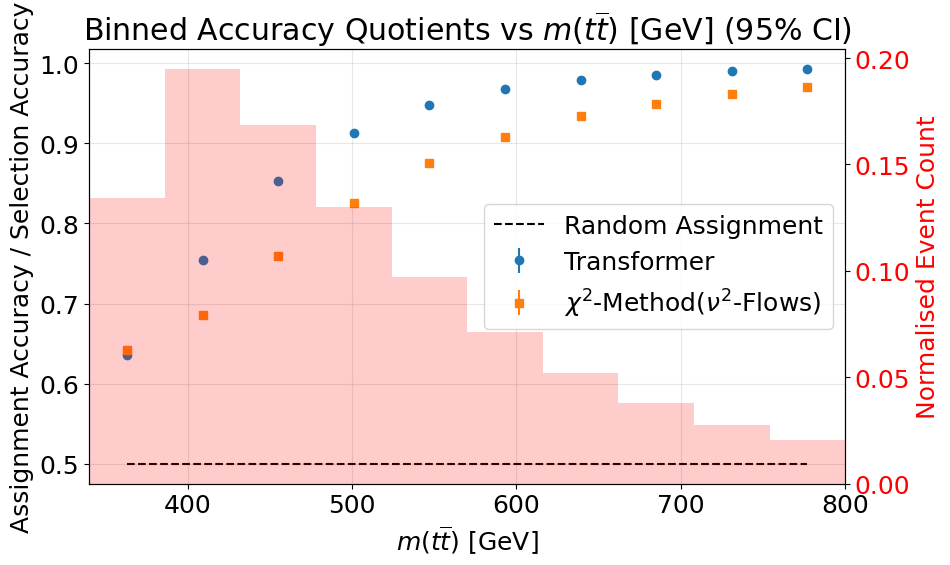

In [11]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_mass.pdf")

In [12]:
evaluator.save_accuracy_latex_table(
    n_bootstrap=100, confidence=0.95, save_dir=PLOTS_DIR
)

LaTeX table saved to plots/RegressionTransformer/reconstruction_accuracies_table.tex



Computing bootstrap confidence intervals...
Ground truth: Ground Truth (skipping)
Transformer: 0.8230 [0.8228, 0.8233]
$\chi^2$-Method($\nu^2$-Flows): 0.7394 [0.7392, 0.7396]


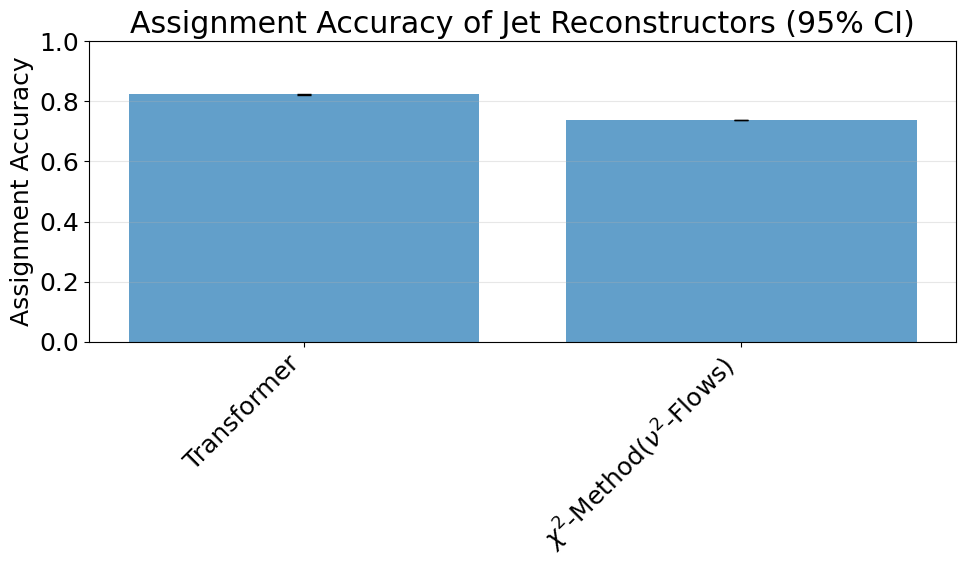

In [13]:
fig, ax = evaluator.plot_all_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing bootstrap confidence intervals...
Ground truth: Ground Truth (skipping)
Transformer: 0.9596 [0.9594, 0.9598]
$\chi^2$-Method($\nu^2$-Flows): 0.9232 [0.9229, 0.9234]


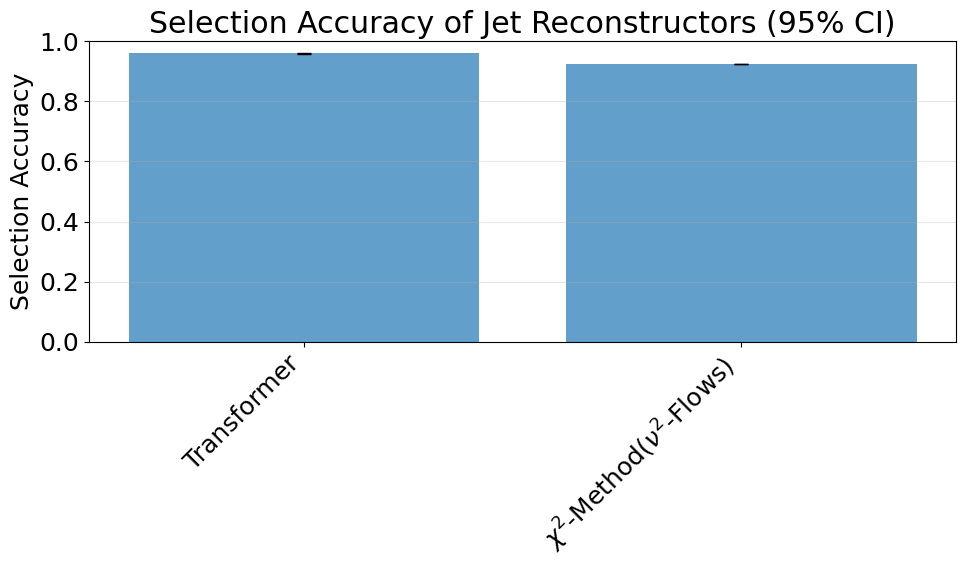

In [14]:
fig, ax = evaluator.plot_all_selection_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")


Computing binned accuracy for N_jets...


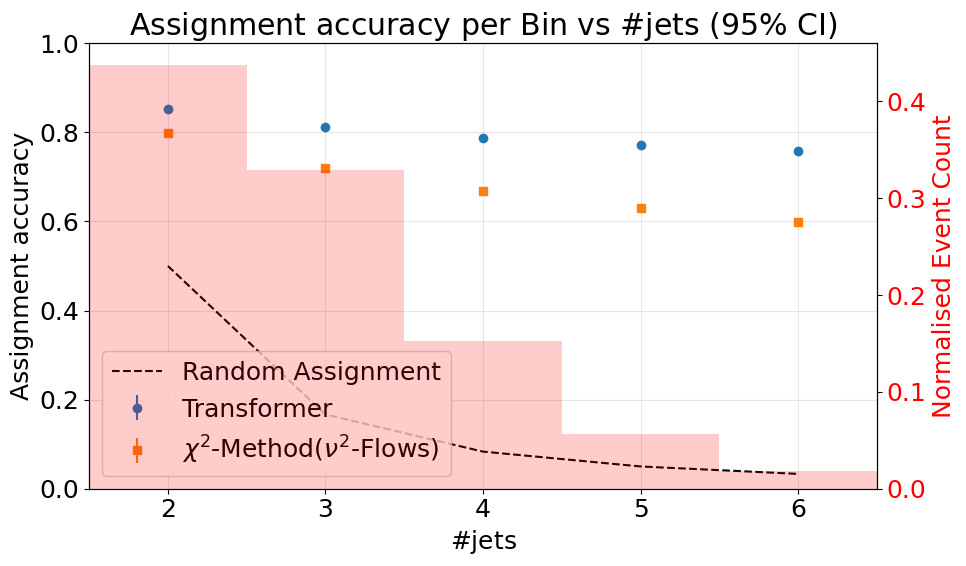

In [15]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")


Computing binned accuracy quotients for N_jets...


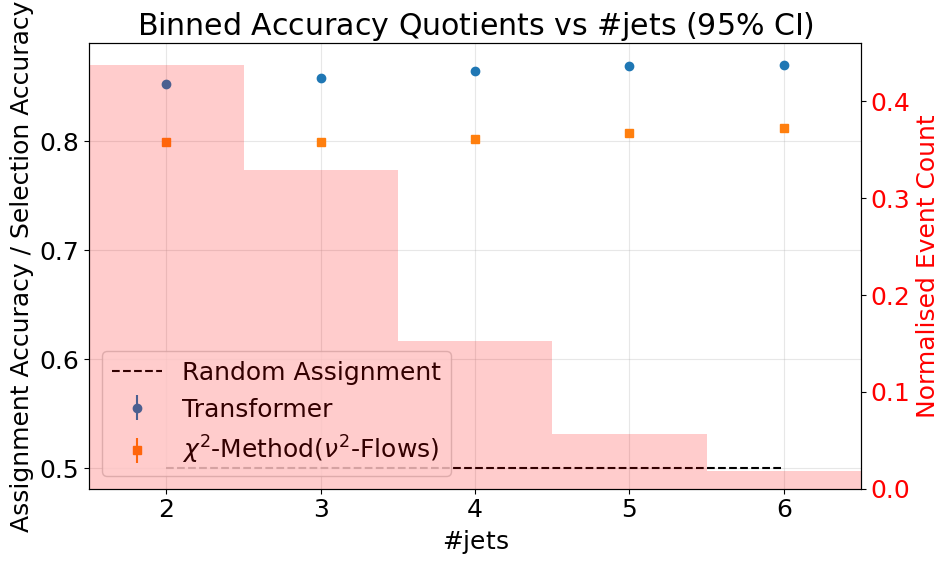

In [16]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.set_xlim(2, data_config.max_jets + 1)
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_N_jets.pdf")


Computing binned accuracy for truth_ttbar_mass...


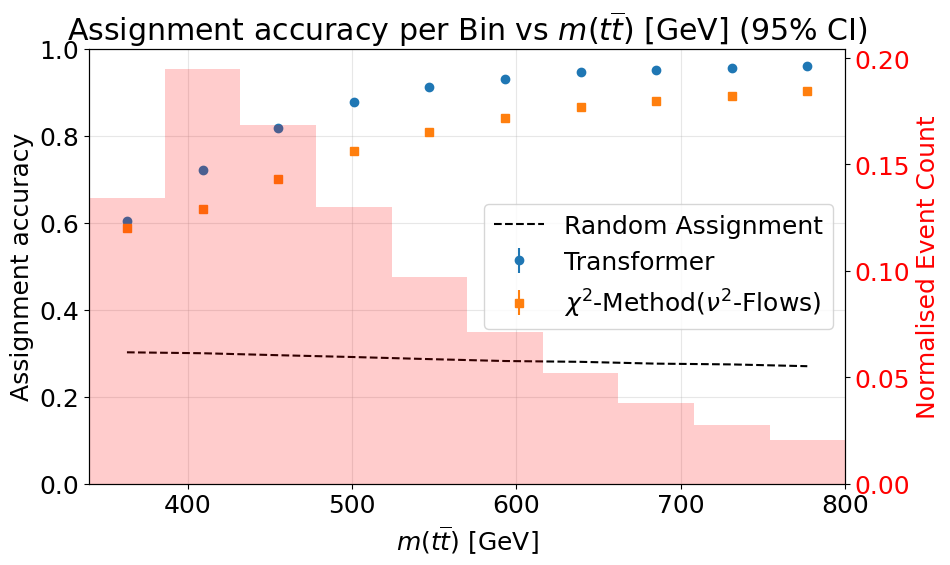

In [17]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


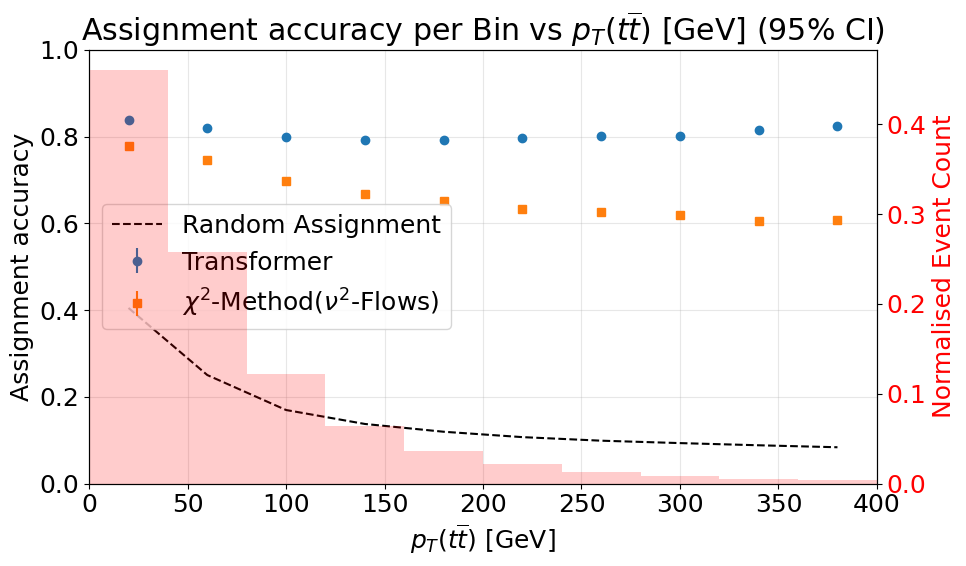

In [18]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy quotients for truth_ttbar_pt...


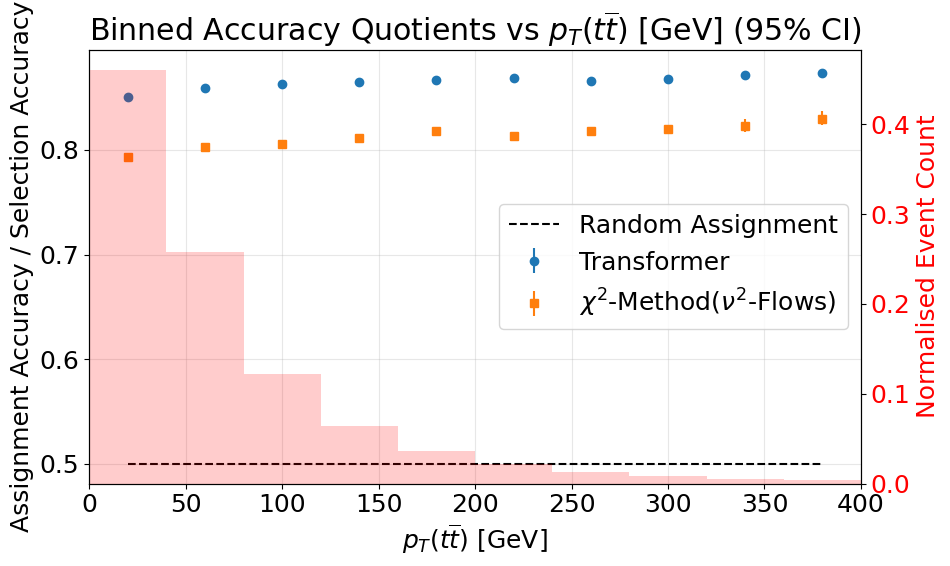

In [19]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_pT.pdf")


Computing binned accuracy for dR_l1l2...


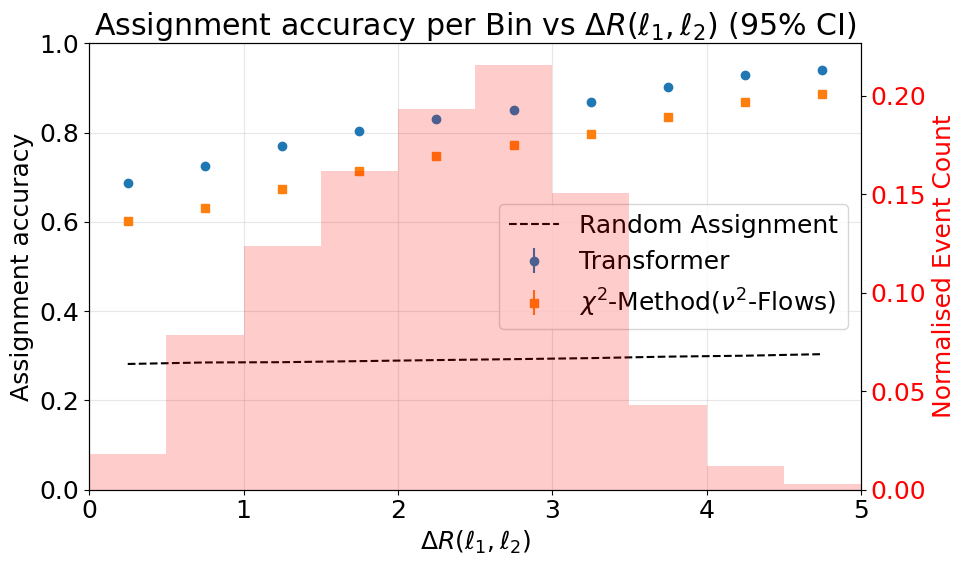

In [20]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="dR_l1l2",
    fancy_feature_label=r"$\Delta R(\ell_1,\ell_2)$",
    xlims=(0, 5),
    bins=10,
    n_bootstrap=10,
)
ax.set_xlim(0, 5)
fig.savefig(PLOTS_DIR + "binned_accuracy_dR_l1l2.pdf")


Computing binned accuracy for truth_ttbar_mass...


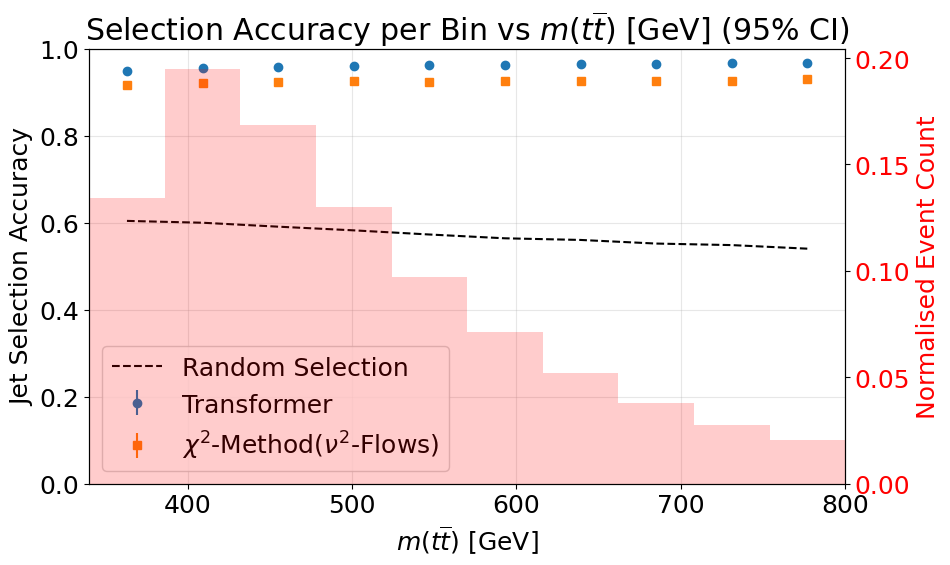

In [21]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")


Computing binned accuracy for N_jets...


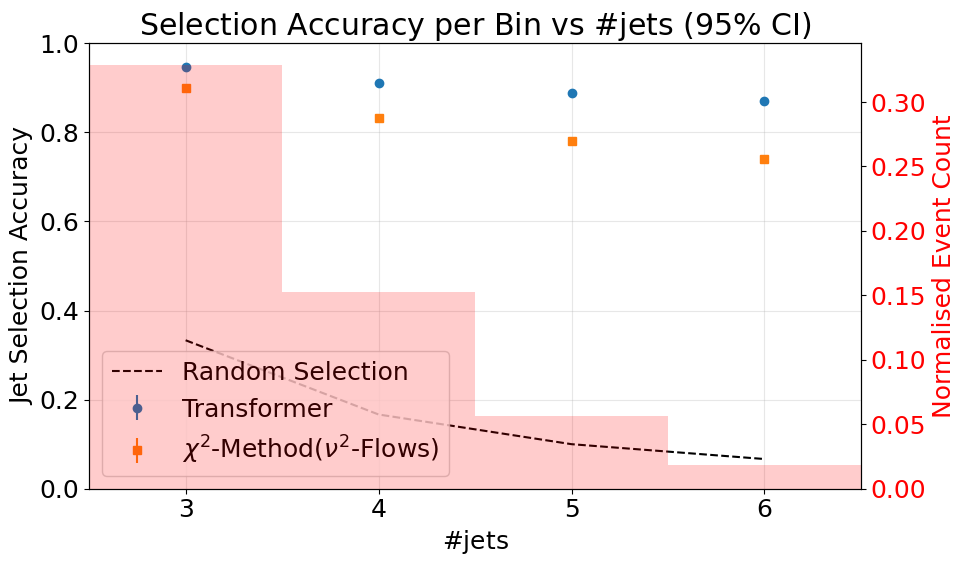

In [22]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(3, data_config.max_jets + 1),
    bins=data_config.max_jets - 2,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(3, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(3, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_N_jets.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


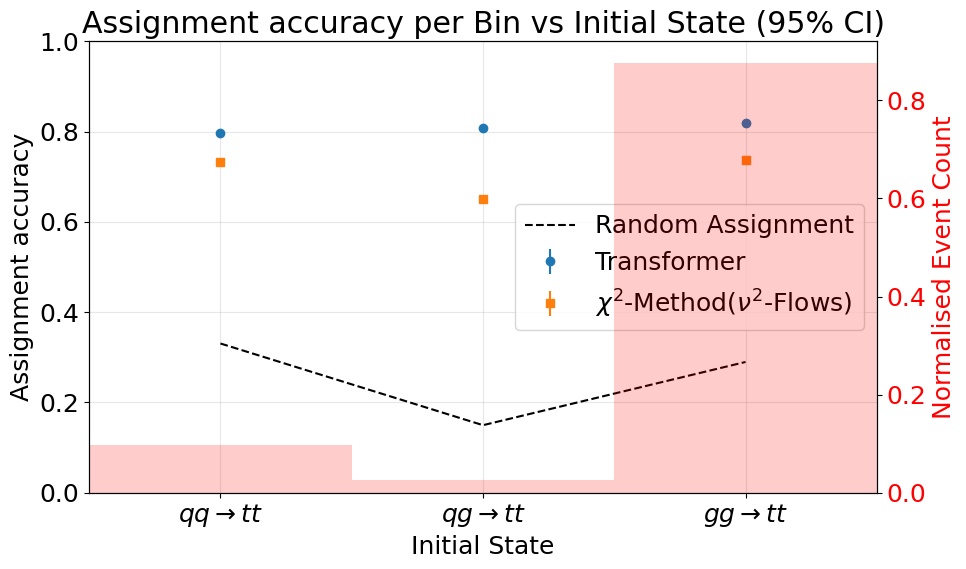

In [23]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


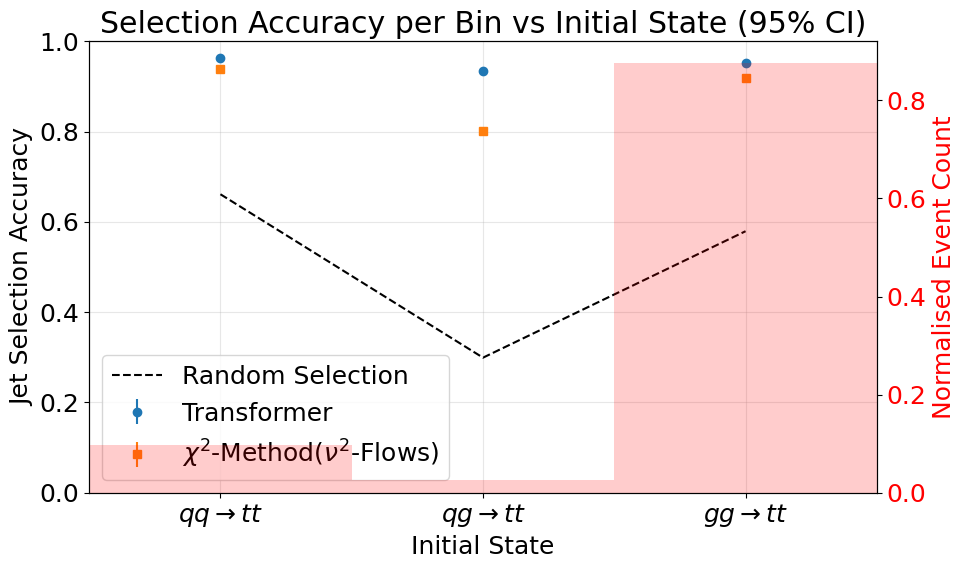

In [24]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_initial_state.pdf")


Computing binned accuracy quotients for truth_initial_parton_num_gluons...


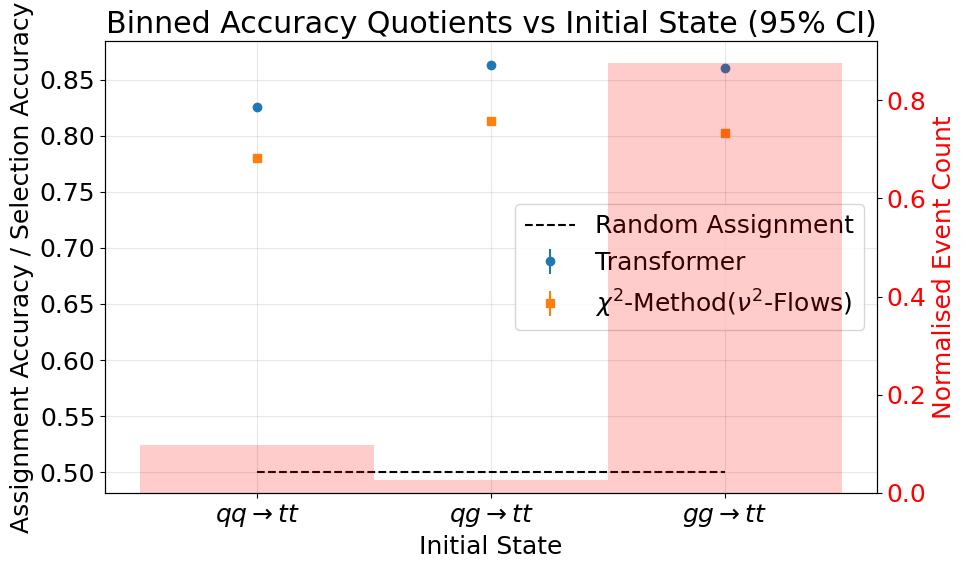

In [25]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_initial_state.pdf")

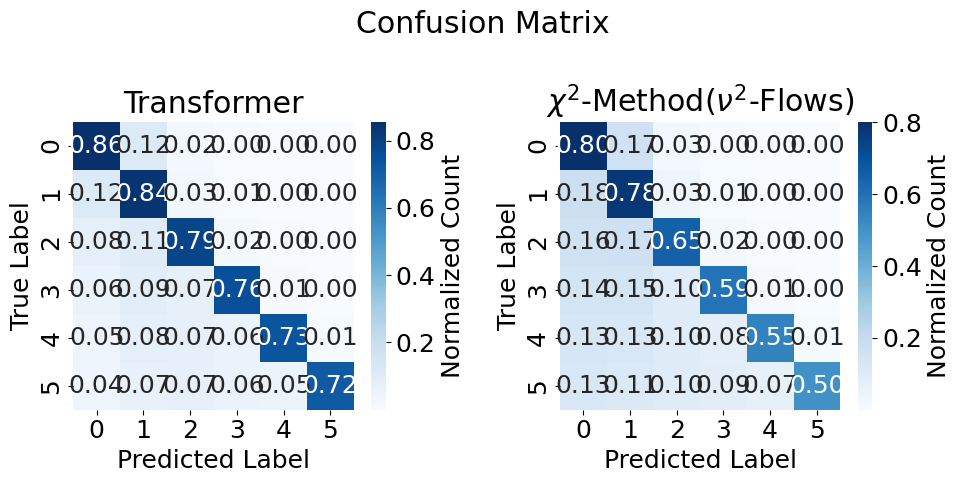

In [26]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

TypeError: compute_complementarity_matrix() missing 1 required positional argument: 'self'

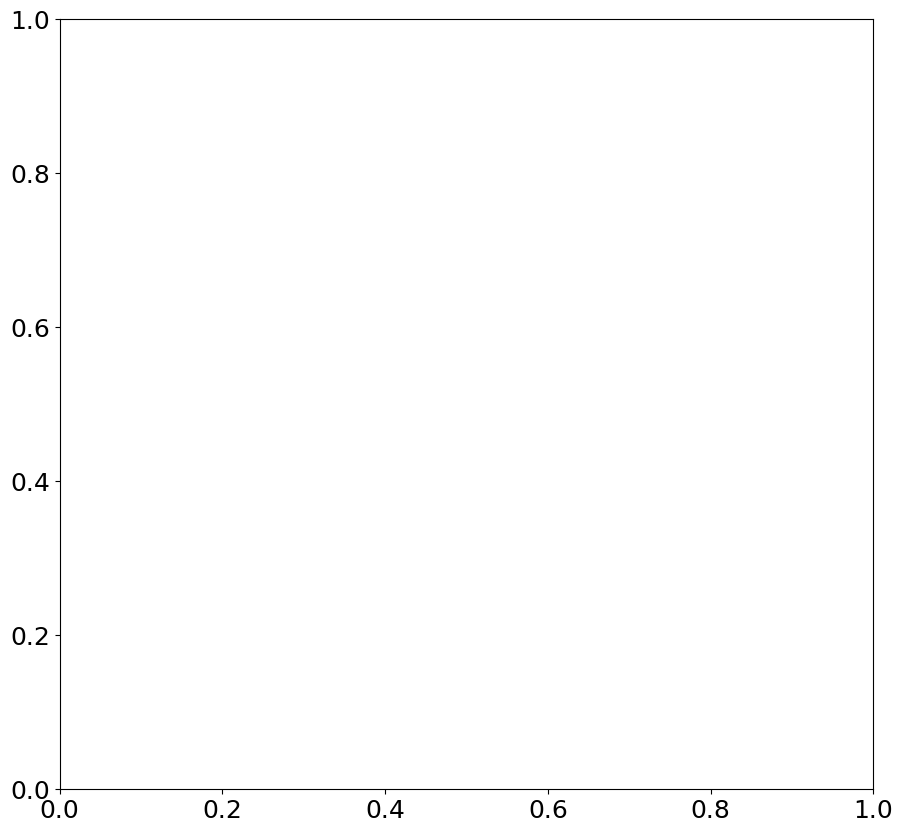

In [27]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(10.5, 10))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")